# Telecomunicaciones: identificar operadores ineficaces

## Abrir el archivo de datos y leer la información general

In [44]:
#importar librerias
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats as st
import numpy as np

In [45]:
#leer el dataset 1
dt=pd.read_csv('E:/proyectos/proyecto13/telecom_dataset_us.csv')
print(dt)
print(dt.info())

       user_id                       date direction internal  operator_id  \
0       166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1       166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2       166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3       166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4       166377  2019-08-05 00:00:00+03:00       out    False     880022.0   
...        ...                        ...       ...      ...          ...   
53897   168606  2019-11-10 00:00:00+03:00       out     True     957922.0   
53898   168606  2019-11-11 00:00:00+03:00       out     True     957922.0   
53899   168606  2019-11-15 00:00:00+03:00       out     True     957922.0   
53900   168606  2019-11-15 00:00:00+03:00       out     True     957922.0   
53901   168606  2019-11-19 00:00:00+03:00        in    False          NaN   

       is_missed_call  calls_count  call_duration  total_call_duration  
0 

In [46]:
#leer el dataset de los clientes
clients=pd.read_csv('telecom_clients_us.csv')
print(clients)
print(clients.info())

     user_id tariff_plan  date_start
0     166713           A  2019-08-15
1     166901           A  2019-08-23
2     168527           A  2019-10-29
3     167097           A  2019-09-01
4     168193           A  2019-10-16
..       ...         ...         ...
727   166554           B  2019-08-08
728   166911           B  2019-08-23
729   167012           B  2019-08-28
730   166867           B  2019-08-22
731   166565           B  2019-08-08

[732 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None


## Lleva a cabo el análisis exploratorio de datos

### Convierte los datos en los tipos necesarios.

In [47]:
#convertir date a formato fecha del dataset dt
dt['date']=pd.to_datetime(dt['date'])
#convertir columnas a tipo category
dt['direction']= dt['direction'].astype('category')
#convertir date a formato fecha del dataset clients
clients['date_start']=pd.to_datetime(clients['date_start'])
#convertir columnas a tipo category
clients['tariff_plan']=clients['tariff_plan'].astype('category')

### Encuentra y elimina errores en los datos. Asegúrate de explicar qué errores encontraste y cómo los eliminaste.

In [48]:
#eliminar las filas nulas del datasets dt de la fila operator_id
dt.dropna(inplace=True)


### Une los dos datasets

In [49]:
df= dt.merge(clients,on='user_id')
df

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,B,2019-08-01
3,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,B,2019-08-01
4,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...
45665,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,False,1,0,25,C,2019-10-31
45666,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,True,1,0,38,C,2019-10-31
45667,168606,2019-11-11 00:00:00+03:00,out,True,957922.0,False,2,479,501,C,2019-10-31
45668,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190,C,2019-10-31


## Identificar operadores ineficaces

se considera operador ineficaz si cumple las siguientes tres caracteristicas

### Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas)

#### contar el numero de llamadas perdidas por operador 

In [50]:
loss_call=df.groupby('operator_id')['is_missed_call'].sum().reset_index()
loss_call

,operator_id,is_missed_call
0,879896.0,50
1,879898.0,100
2,880020.0,7
3,880022.0,33
4,880026.0,94
...,...,...
1087,972410.0,2
1088,972412.0,2
1089,972460.0,3
1090,973120.0,1


#### considerar las llamadas de duracion 0 como llamadas perdidas

In [51]:
#identificar las llamadas con duracion 0
loss_cero=df[df['total_call_duration']==0].groupby('operator_id').count()
loss_call_cero_duration=loss_cero['is_missed_call'].reset_index()
#unir las llamadas de duracion cero a las llamadas perdidas
loss_call= pd.concat([loss_call,loss_call_cero_duration],axis=0)
loss_call

,operator_id,is_missed_call
0,879896.0,50
1,879898.0,100
2,880020.0,7
3,880022.0,33
4,880026.0,94
...,...,...
322,962658.0,2
323,964510.0,2
324,965542.0,2
325,967310.0,1


#### realizar un histograma para el numero de llamadas perdidas por operador y halla el promedio

<Axes: xlabel='is_missed_call', ylabel='Count'>

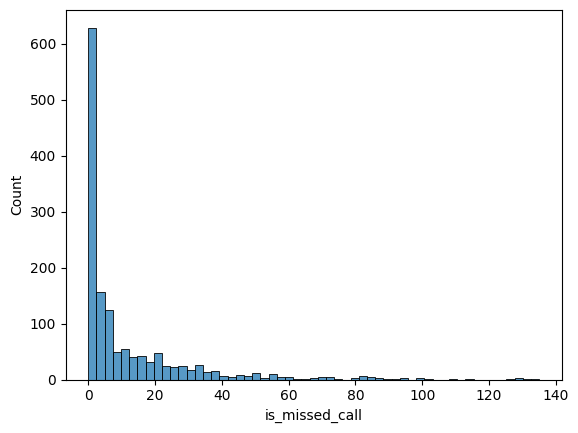

In [52]:
sns.histplot(data=loss_call['is_missed_call'])

In [53]:
loss_call.describe()

,operator_id,is_missed_call
count,1419.000000,1419.000000
mean,924349.791402,11.608175
std,22896.226742,18.560543
min,879896.000000,0.000000
25%,905564.000000,1.000000
50%,923646.000000,3.000000
75%,941821.000000,15.000000
max,973286.000000,135.000000


#### almacenar los operadores que superan la media de llamadas perdidas por operador

In [54]:
operator_with_missed_call=loss_call[loss_call['is_missed_call']>loss_call['is_missed_call'].mean()]
operator_with_missed_call

,operator_id,is_missed_call
0,879896.0,50
1,879898.0,100
3,880022.0,33
4,880026.0,94
5,880028.0,91
...,...,...
44,893804.0,20
66,900180.0,18
75,901880.0,17
296,952468.0,14


se obtuvo 358 operadores que superaron el umbral de perdidas de llamadas

### Se considera que un operador es ineficaz si tiene un tiempo de espera prolongado para las llamadas entrantes

#### restar call_duration a total_call_duration para hallar el tiempo de espera

In [55]:
wait_call=df.groupby('operator_id')['total_call_duration'].sum()-df.groupby('operator_id')['call_duration'].sum()
wait_call=wait_call.reset_index()
wait_call

,operator_id,0
0,879896.0,14166
1,879898.0,112965
2,880020.0,334
3,880022.0,4375
4,880026.0,23992
...,...,...
1087,972410.0,1498
1088,972412.0,1050
1089,972460.0,801
1090,973120.0,20


#### realizar un histograma para el tiempo de espera y halla el promedio

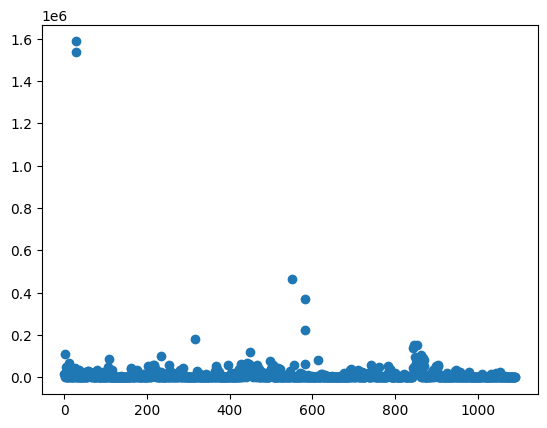

In [56]:
x_values = pd.Series(range(0, len(wait_call[0])))
plt.scatter(x_values, wait_call[0])

[ 14141.2   49424.95 106576.8 ]


<Axes: xlabel='0', ylabel='Count'>

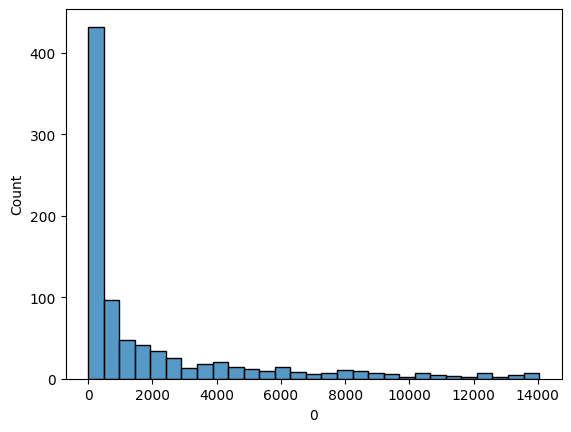

In [57]:
#filtrar los datos anomalos en wait_call
print(np.percentile(wait_call[0], [80, 95, 99]))
abnormal_users=wait_call[wait_call[0]>14141]['operator_id']
# excluir los datos anomalos del grafico
wait_call_filtered=wait_call[~wait_call['operator_id'].isin(abnormal_users)]
sns.histplot(data=wait_call_filtered[0])


In [58]:
wait_call_filtered[0].describe()

count      873.000000
mean      2012.378007
std       3097.340749
min          0.000000
25%        104.000000
50%        499.000000
75%       2429.000000
max      14042.000000
Name: 0, dtype: float64

#### almacenar los operadores que superan el promedio de tiempo de espera

In [59]:
operator_with_wait_call=wait_call[wait_call[0]>wait_call[0].mean()]
operator_with_wait_call
oprator_with_wait_call_filtered=wait_call_filtered[wait_call_filtered[0]>wait_call_filtered[0].mean()]

se observa 230 operadores que superaron el umbral de tiempo de espera

### Se considera que un operador es ineficaz si tiene un numero de llamadas salientes reducido

#### contar el numero de llamadas out para cada operador

In [60]:
call_out=df[df['direction']=='out'].groupby('operator_id').count()
call_out['direction']

operator_id
879896.0    105
879898.0    187
880020.0     14
880022.0     68
880026.0    179
           ... 
972408.0      3
972410.0      4
972412.0      4
972460.0      7
973120.0      2
Name: direction, Length: 882, dtype: int64

####  realizar un histograma para el numero de llamadas out para cada operador y halla el promedio

35.96031746031746


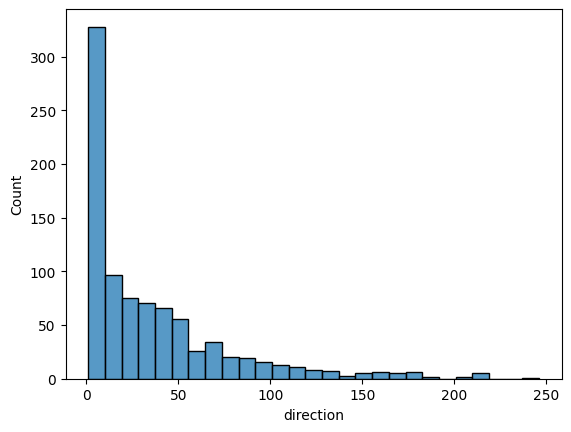

In [61]:
sns.histplot(data=call_out['direction'])
print(call_out['direction'].mean())

#### almacenar a los operadores que tienen un numero de llamadas menor que el promedio

In [62]:
operator_with_less_out=call_out[call_out['direction']<call_out['direction'].mean()]
operator_with_less_out=operator_with_less_out['direction'].reset_index()
operator_with_less_out

,operator_id,direction
0,880020.0,14
1,880240.0,14
2,881278.0,8
3,882478.0,1
4,882688.0,8
...,...,...
551,972408.0,3
552,972410.0,4
553,972412.0,4
554,972460.0,7


hay 556 operadores con deficiencia de llamadas salientes

### identificar a los operadores que cumplen con las tres condiciones anteriores y almacenarlos en la variable ineficaz

In [63]:
conjunto1 = set(operator_with_missed_call['operator_id'])
conjunto2 = set(operator_with_wait_call['operator_id'])
conjunto3 = set(operator_with_less_out['operator_id'])

# Encontrar la intersección de los conjuntos
ineficaz = list(conjunto1.intersection(conjunto2, conjunto3))

# Ahora, ineficaz contiene los elementos presentes en las tres series
print(f'Numero de operadores ineficientes:{len(ineficaz)}')

Numero de operadores ineficientes:39


## Prueba las hipótesis estadísticas

### Hay diferencia significativa entre el tamaño de las muestras de los operadores ineficaces en las tres tarifas actuales de la clientela

In [64]:
# filtrar los operadores ineficaces en el df para la tarifa a 
operator_ineficiente_a=df[df['tariff_plan']=='A']['operator_id'].isin(ineficaz).astype(int)
operator_ineficiente_a
#filtrar los operadors ineficientes en el df para la tarifa b
operator_ineficiente_b=df[df['tariff_plan']=='B']['operator_id'].isin(ineficaz).astype(int)
#filtrar los operadors ineficientes en el df para la tarifa c
operator_ineficiente_c=df[df['tariff_plan']=='C']['operator_id'].isin(ineficaz).astype(int)
#funcion para hacer las pruebas z
def realizar_prueba_z_e_imprimir_resultado(grupo_1, grupo_2, alpha=0.05):
    # Realizar la prueba de diferencia de proporciones:
    z_stat, p_value = proportions_ztest([grupo_1.sum(), grupo_2.sum()], [len(grupo_1), len(grupo_2)])


    if p_value < alpha:
        print("Hay una diferencia estadísticamente significativa.")
    else:
        print("No hay evidencia suficiente para afirmar que hay una diferencia estadísticamente significativa.")
#realizar la primera prueba
realizar_prueba_z_e_imprimir_resultado(operator_ineficiente_a,operator_ineficiente_b)
#realizar la segunda prueba
realizar_prueba_z_e_imprimir_resultado(operator_ineficiente_b,operator_ineficiente_c)
#realizar la tercera prueba
realizar_prueba_z_e_imprimir_resultado(operator_ineficiente_c,operator_ineficiente_a)

Hay una diferencia estadísticamente significativa.
Hay una diferencia estadísticamente significativa.
Hay una diferencia estadísticamente significativa.


- H0: las proporciones de operadores ineficentes entre los grupos de las tarifas son iguales
- H1: las proporciones de operadores ineficientes entre los grupos son diferentes

En este caso rechazamos la hipotesis nula ya que en los tres tipos de tarifa las proporciones de los operadores ineficientes tuvieron una diferencia estadísticamente significativa.

### Las llamadas entrantes perdidas promedio de los operadores eficaces y los operadores ineficaces son diferentes

- H0: el promedio de las llamadas entrantes promedio de los operadores eficaces y los operadores ineficaces son iguales
- H1: el promedio de las llamadas entrantes promedio de los operadores eficaces y los operadores ineficaces son diferentes

In [65]:
missed_call_operator_eficaz=df[~df['operator_id'].isin(ineficaz)]['is_missed_call'].astype(int)
missed_call_operator_ineficaz=df[df['operator_id'].isin(ineficaz)]['is_missed_call'].astype(int)
alpha = 0.05
results = st.mannwhitneyu(missed_call_operator_eficaz,missed_call_operator_ineficaz)
print('valor p:',results.pvalue)
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula: la diferencia es estadísticamente significativa")
else:
    print("No podemos rechazar la hipótesis nula:  no podemos sacar conclusiones sobre la diferencia")

valor p: 5.801112668407573e-19
Rechazamos la hipótesis nula: la diferencia es estadísticamente significativa


### el tiempo de espera de los operadores eficaces y los ineficaces son diferentes

- H0: el tiempo de espera entre los operadores eficaces y los ineficaces es igual
- H1: el tiempo de espera entre los operadores eficaces y los ineficaces son diferentes

In [66]:
wait_time_eficaz=wait_call[~wait_call['operator_id'].isin(ineficaz)][0]
wait_time_ineficaz=wait_call[wait_call['operator_id'].isin(ineficaz)][0]
alpha = 0.05
results = st.mannwhitneyu(wait_time_eficaz,wait_time_ineficaz)
print('valor p:',results.pvalue)
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula :la diferencia es estadísticamente significativa")
else:
    print("No podemos rechazar la hipótesis nula:  no podemos sacar conclusiones sobre la diferencia")

valor p: 2.3980557541397132e-17
Rechazamos la hipótesis nula :la diferencia es estadísticamente significativa


#### el tiempo de espera de los operadores eficaces y los ineficaces son diferentes utilizando los datos filtrados

- H0: el tiempo de espera entre los operadores eficaces y los ineficaces es igual
- H1: el tiempo de espera entre los operadores eficaces y los ineficaces son diferentes

In [67]:
wait_time_eficaz_filtered=wait_call_filtered[~wait_call_filtered['operator_id'].isin(ineficaz)][0]
wait_time_ineficaz_filtered=wait_call_filtered[wait_call_filtered['operator_id'].isin(ineficaz)][0]
alpha = 0.05
results = st.mannwhitneyu(wait_time_eficaz_filtered,wait_time_ineficaz_filtered)
print('valor p:',results.pvalue)
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula :la diferencia es estadísticamente significativa")
else:
    print("No podemos rechazar la hipótesis nula:  no podemos sacar conclusiones sobre la diferencia")

valor p: 0.003020801813213639
Rechazamos la hipótesis nula :la diferencia es estadísticamente significativa


### el numero de llamadas salientes de los operadares eficaces y los ineficaces son diferentes

- H0: el numero de llamadas salientes de los operadores eficaces e ineficaces son los mismos
- H1: el numero de llamadas salientes de los operadores eficaces e ineficaces son diferentes

In [68]:
less_out_eficaz=operator_with_less_out[~operator_with_less_out['operator_id'].isin(ineficaz)]['direction']
less_out_ineficaz=operator_with_less_out[operator_with_less_out['operator_id'].isin(ineficaz)]['direction']
alpha = 0.05
results = st.mannwhitneyu(less_out_eficaz,less_out_ineficaz)
print('valor p:',results.pvalue)
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula:la diferencia es estadísticamente significativa")
else:
    print("No podemos rechazar la hipótesis nula:  no podemos sacar conclusiones sobre la diferencia")

valor p: 1.5812433025295902e-19
Rechazamos la hipótesis nula:la diferencia es estadísticamente significativa


## Escribe una conclusión general

- Hay una diferencia entre los operadores ineficaces con respecto a las muestras tomadas de cada tarifa de la clientela, por lo que habria que analizar en cada especifico como es el comportamiento de ciertos operadores en cada plan para determinar una posible causa
- De las tres pruebas estidisticas hechas acerca de las condiciones tiene que cumplir un operador para que se le considere ineficaz comparado con un operador eficaz, en todas incluida la prueba filtrada con los datos atipicos en el caso de tiempo de espera prolongado dieron que ambos grupos tienen una diferencia significativa hablando de las medias por lo tanto podemos concluir que confirmamos los criterios que se toman en cuenta para identificar los operadores ineficaces.